In [1]:
from torch import nn 
from torch import optim
import torchvision.transforms as transforms
import torch, torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./data/list.csv')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [3]:
IMAGES_PATH = './data/720p'
MASKS_PATH = './data/mask'

In [5]:
imgs_set = set(os.listdir(IMAGES_PATH))
masks_set = set(os.listdir(MASKS_PATH))

imgs_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in imgs_set)
masks_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in masks_set)

In [6]:
len(imgs_set), len(masks_set)

(28594, 28540)

In [7]:
len(imgs_set.difference(masks_set)), len(masks_set.difference(imgs_set))

(54, 0)

Есть 54 изображения, для которых нет масок. Уберем их из датафрейма.

In [8]:
not_mask = imgs_set.difference(masks_set)

not_mask = [f'image{i}.jpg' for i in not_mask]
not_mask

['image00010751.jpg',
 'image00010718.jpg',
 'image00010773.jpg',
 'image00010735.jpg',
 'image00010774.jpg',
 'image00010744.jpg',
 'image00010724.jpg',
 'image00010805.jpg',
 'image00010742.jpg',
 'image00010754.jpg',
 'image00010736.jpg',
 'image00010813.jpg',
 'image00010766.jpg',
 'image00010767.jpg',
 'image00010717.jpg',
 'image00010783.jpg',
 'image00010810.jpg',
 'image00010740.jpg',
 'image00010795.jpg',
 'image00010788.jpg',
 'image00010732.jpg',
 'image00010786.jpg',
 'image00010722.jpg',
 'image00010803.jpg',
 'image00010780.jpg',
 'image00010752.jpg',
 'image00010799.jpg',
 'image00010781.jpg',
 'image00010800.jpg',
 'image00010807.jpg',
 'image00010804.jpg',
 'image00010730.jpg',
 'image00010737.jpg',
 'image00010759.jpg',
 'image00010793.jpg',
 'image00010811.jpg',
 'image00010806.jpg',
 'image00010745.jpg',
 'image00010761.jpg',
 'image00010769.jpg',
 'image00010801.jpg',
 'image00010716.jpg',
 'image00010776.jpg',
 'image00010721.jpg',
 'image00010763.jpg',
 'image000

In [9]:
df = df.loc[~df['filename'].isin(not_mask)]
df.reset_index(drop=True, inplace=True)

In [10]:
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


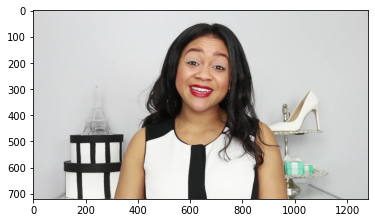

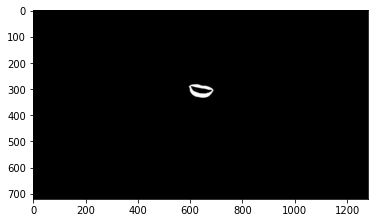

In [11]:
idx = np.random.randint(len(df))

sample = df.iloc[idx]

img_path = os.path.join(IMAGES_PATH, sample['filename'])
mask_path = os.path.join(MASKS_PATH, sample['mask'])

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
mask = cv2.imread(mask_path)[:, :, 1]

plt.imshow(img)
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

In [12]:
class LipsSegmentationDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        
        img_path = os.path.join(IMAGES_PATH, data['filename'])
        mask_path = os.path.join(MASKS_PATH, data['mask'])
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
        mask = cv2.imread(mask_path)[:, :, 1]
        
        if self.transform:
            img, mask = self.transform(img, mask)
            
        return img, mask
    
    def __len__(self):
        return len(self.df)

In [13]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [14]:
train_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00028042.jpg,1280,720,Lips,689,333,849,420,mask00028042.png
1,image00002827.jpg,1280,720,Lips,591,333,679,387,mask00002827.png
2,image00016865.jpg,1280,720,Lips,655,194,719,236,mask00016865.png
3,image00021794.jpg,1280,720,Lips,592,291,692,343,mask00021794.png
4,image00005674.jpg,1280,720,Lips,559,469,734,558,mask00005674.png


In [15]:
test_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00007579.jpg,1280,720,Lips,650,385,741,445,mask00007579.png
1,image00018710.jpg,1280,720,Lips,653,170,717,211,mask00018710.png
2,image00019615.jpg,1280,720,Lips,655,241,708,279,mask00019615.png
3,image00011859.jpg,1280,720,Lips,658,386,772,442,mask00011859.png
4,image00023582.jpg,1280,720,Lips,615,250,685,309,mask00023582.png


Augmentation

In [16]:
transform = A.Compose([
    A.RandomBrightnessContrast(),
    A.HorizontalFlip(),
    A.Rotate(limit=90, border_mode=0, value=0),
    A.GaussNoise(var_limit=(50.0, 100.0)),
    A.ChannelShuffle(),
    A.OpticalDistortion(), 
    A.GridDistortion(distort_limit=(-0.15, 0.15), border_mode=0, value=0), 
    A.Transpose()
])

to_tensor = transforms.ToTensor()

def tensor_img_mask(img, mask, shape=(256, 256)):
    img, mask = cv2.resize(img, shape), cv2.resize(mask, shape)
    return to_tensor(img), to_tensor(mask)

def transform_img_mask(img, mask, shape=(256, 256)):
    img, mask = cv2.resize(img, shape), cv2.resize(mask, shape)
    transformed = transform(image=img, mask=mask)
    img, mask = transformed['image'], transformed['mask']
    img, mask = to_tensor(img), to_tensor(mask)
    return img, mask

In [17]:
train_dataset = LipsSegmentationDataset(train_df, transform=transform_img_mask)
test_dataset = LipsSegmentationDataset(test_df, transform=tensor_img_mask)

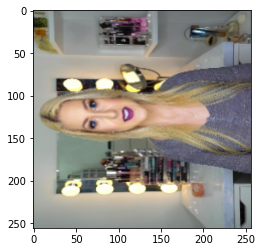

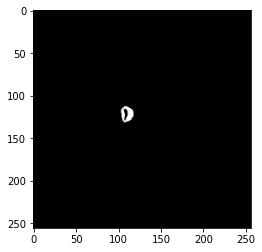

In [18]:
idx = int(np.random.random() * len(train_dataset))

img, mask = train_dataset[idx]

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(mask.permute(1, 2, 0), cmap='gray')
plt.show()

Реализуем сеть с архитектурой **LinkNet**.

Зададим классы блоков, из которых будем строить сеть.

**EncoderBlock:**

* сверточный слой (ядро (4, 4), шаг (2, 2), padding (1, 1));
* функция активации LeakyReLU (чтобы не занулять отрицательные значения);
* слой BatchNormalization.

Таким образом, на выходе блока получаем тензор размерностью:

output_shape = (n_samples, n_channels, input_width/2, input_height/2)

**DecoderBlock:**

* слой обратной свертки (ядро (4, 4), шаг (2, 2), padding (1, 1));
* функция активации LeakyReLU (чтобы не занулять отрицательные значения);
* слой BatchNormalization.

Таким образом, на выходе блока получаем тензор размерностью:

output_shape = (n_samples, n_channels, input_width * 2, input_height * 2)

In [19]:
class EncoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, batchnorm=True):
        super().__init__()
        
        self.batchnorm=batchnorm
        
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )

        self.activation = nn.LeakyReLU(0.1)
        
        if self.batchnorm:
            self.batchnorm = nn.BatchNorm2d(
                num_features=out_channels
            )
        
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.activation(x)

        if self.batchnorm:
            x = self.batchnorm(x)
        
        return x
    
    
class DecoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upconv = nn.ConvTranspose2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )
        
        
        self.activation = nn.LeakyReLU(0.1)

        self.batchnorm = nn.BatchNorm2d(
            num_features=out_channels
        )
        
        
    def forward(self, x, skip_in):
        
        x = self.upconv(x)
        x = x + skip_in
        x = self.activation(x)
        
        x = self.batchnorm(x)
        
        return x

In [20]:
class LinkNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # (3, 256, 256) -> (32, 128, 128)
        self.e1 = EncoderBlock(
            in_channels=3, 
            out_channels=32
        )
        
        # (32, 128, 128) -> (64, 64, 64)
        self.e2 = EncoderBlock(
            in_channels=32, 
            out_channels=64
        )
        
        # (64, 64, 64) -> (128, 32, 32)
        self.e3 = EncoderBlock(
            in_channels=64, 
            out_channels=128
        )
        
        # (128, 32, 32) -> (256, 16, 16)
        self.e4 = EncoderBlock(
            in_channels=128, 
            out_channels=256
        )
        
        # (256, 16, 16) -> (512, 8, 8)
        self.e5 = EncoderBlock(
            in_channels=256, 
            out_channels=512
        )
        
        # bottleneck (512, 8, 8) -> (512, 4, 4)
        self.b = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )
        
        # (512, 4, 4) -> (512, 8, 8)
        self.d1 = DecoderBlock(
            in_channels=512, 
            out_channels=512
        )
        
        # (512, 8, 8) -> (256, 16, 16)
        self.d2 = DecoderBlock(
            in_channels=512, 
            out_channels=256
        )
        
        # (256, 16, 16) -> (128, 32, 32)
        self.d3 = DecoderBlock(
            in_channels=256, 
            out_channels=128
        )
        
        # (128, 32, 32) -> (64, 64, 64)
        self.d4 = DecoderBlock(
            in_channels=128, 
            out_channels=64
        )
        
        # (64, 64, 64) -> (32, 128, 128)
        self.d5 = DecoderBlock(
            in_channels=64, 
            out_channels=32
        )
        
        # output (32, 128, 128) -> (1, 256, 256)
        self.o = nn.ConvTranspose2d(
            in_channels=32, 
            out_channels=1, 
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )
        
    def forward(self, x):
        
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        
        b = self.b(e5)
        b = F.relu(b)
        
        d1 = self.d1(b, e5)
        d2 = self.d2(d1, e4)
        d3 = self.d3(d2, e3)
        d4 = self.d4(d3, e2)
        d5 = self.d5(d4, e1)
        
        output = self.o(d5)
        output = F.sigmoid(output)
        
        return output

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
linknet = LinkNet().to(device)

In [24]:
summary(linknet, input_size=(3, 256, 256), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 32, 128, 128]           1,568
         LeakyReLU-2          [8, 32, 128, 128]               0
       BatchNorm2d-3          [8, 32, 128, 128]              64
      EncoderBlock-4          [8, 32, 128, 128]               0
            Conv2d-5            [8, 64, 64, 64]          32,832
         LeakyReLU-6            [8, 64, 64, 64]               0
       BatchNorm2d-7            [8, 64, 64, 64]             128
      EncoderBlock-8            [8, 64, 64, 64]               0
            Conv2d-9           [8, 128, 32, 32]         131,200
        LeakyReLU-10           [8, 128, 32, 32]               0
      BatchNorm2d-11           [8, 128, 32, 32]             256
     EncoderBlock-12           [8, 128, 32, 32]               0
           Conv2d-13           [8, 256, 16, 16]         524,544
        LeakyReLU-14           [8, 256,

Функция потерь **Dice**.

In [25]:
class DiceLoss(nn.Module):
    
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

In [26]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=8, 
    shuffle=True, 
    num_workers=8, 
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=8, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

In [27]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(linknet.parameters(), lr=0.001)

Вспомогательные функции для обучения модели, валидации и отрисовки картинок.

In [28]:
import time


def draw_imgs(img, mask, pred_mask):
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))

    ax[0].imshow(img.cpu().permute(1, 2, 0))
    ax[0].set_title('Image')

    ax[1].imshow(mask.cpu().permute(1, 2, 0), cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(pred_mask.detach().cpu().permute(1, 2, 0), cmap='gray')
    ax[2].set_title('Predicted Mask')

    plt.show()


def evaluate_model(model, loader, device, criterion):
    loss = 0.
    model.eval()
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss += criterion(output, label).item()
    
    val_loss = loss / len(loader)
    
    print(
        f'- val_loss: {val_loss:.4f}', 
        end='\n')
    
    idx = np.random.randint(len(data))
    draw_imgs(data[idx], label[idx], output[idx])
    
    model.train()
    return loss/len(loader)


def epoch_training(model, criterion, optimizer, train_set, device):
    
    running_loss = 0.0
    
    n_steps = len(train_set)
    steps_n_signs = len(str(n_steps))
    
    for i, data in enumerate(train_set):
        start_time = time.time()
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss = running_loss / (i + 1)
        
        step_duration = time.time() - start_time
        duration = step_duration * n_steps

        print(
            '\r' \
            f'step [{str(i + 1).zfill(steps_n_signs)}/{n_steps}] ' \
            f'- loss: {epoch_loss:.4f} ',
            end='', flush=True)
    
    return epoch_loss


def model_training(model, criterion, optimizer, epochs, device, train_set, valid_set=None):
    history = {
        'loss': []
    }
    if valid_set:
        history['val_loss'] = []
    
    for epoch in range(epochs):

        model.train()
        start_time = time.time()
        
        print(
            f'Epoch {epoch + 1}/{epochs}', 
            end='\n')
        
        epoch_loss = epoch_training(model, criterion, optimizer, train_set, device)
        
        duration = round(time.time() - start_time)
        
        if valid_set:
            val_loss = evaluate_model(model, valid_set, device, criterion)
            history['val_loss'].append(val_loss)
        
        history['loss'].append(epoch_loss)
        
        print(
            '\n' \
            f'duration: {duration}s ({round((duration/len(train_set)) * 1000)}ms/step)\n', 
            end='\n')

    print('Training is finished!')
    
    return history

Epoch 1/7
step [2854/2854] - loss: 0.4957 - val_loss: 0.2972


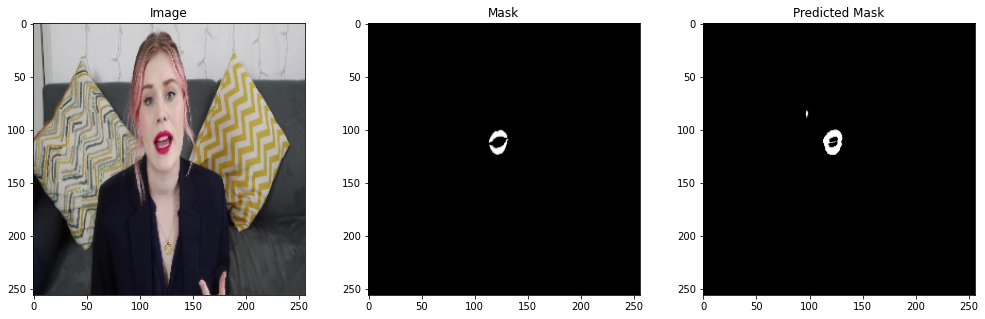


duration: 233s (82ms/step)

Epoch 2/7
step [2854/2854] - loss: 0.2757 - val_loss: 0.1197


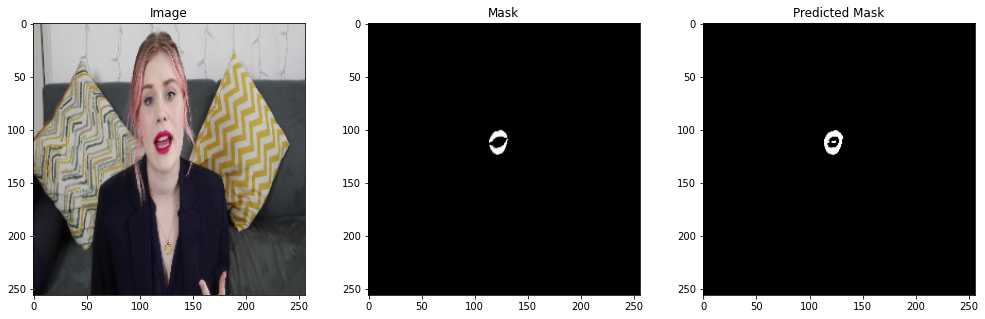


duration: 235s (82ms/step)

Epoch 3/7
step [2854/2854] - loss: 0.1954 - val_loss: 0.1123


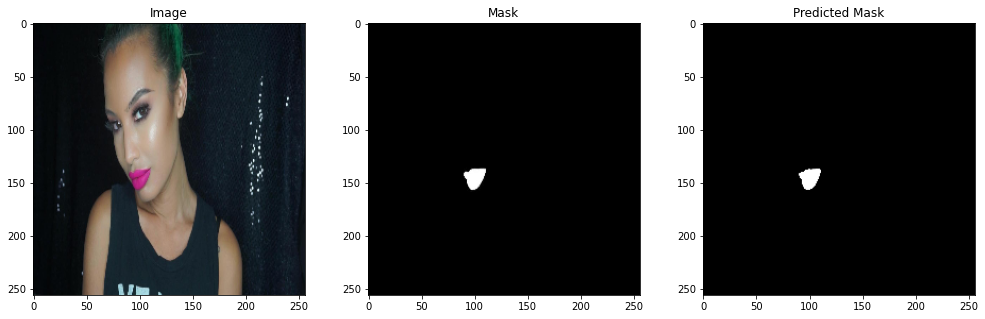


duration: 225s (79ms/step)

Epoch 4/7
step [2854/2854] - loss: 0.1679 - val_loss: 0.0849


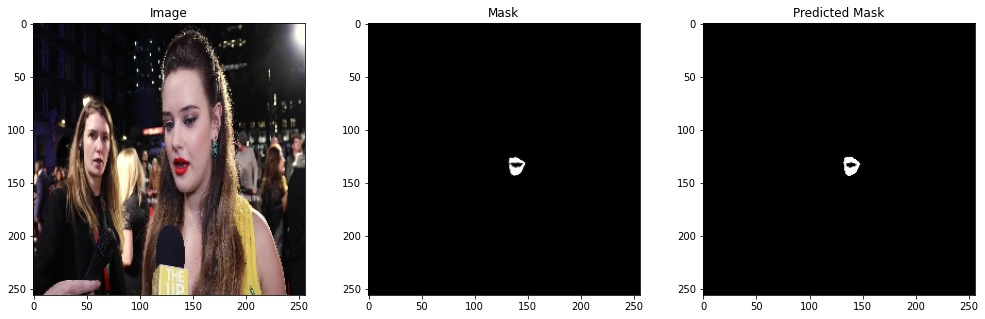


duration: 225s (79ms/step)

Epoch 5/7
step [2854/2854] - loss: 0.1526 - val_loss: 0.0778


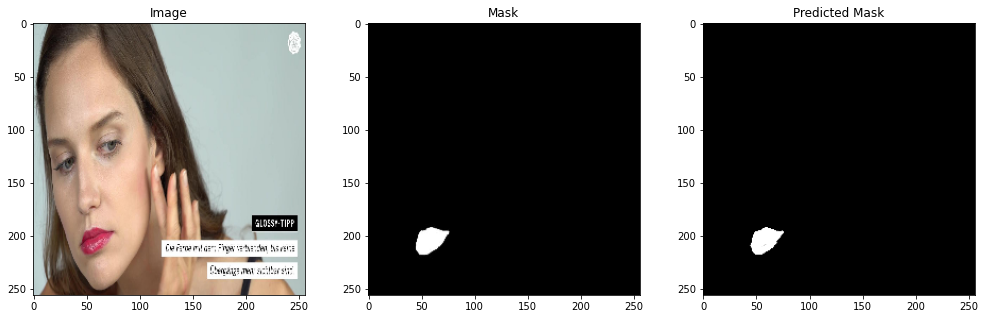


duration: 225s (79ms/step)

Epoch 6/7
step [2854/2854] - loss: 0.1436 - val_loss: 0.0813


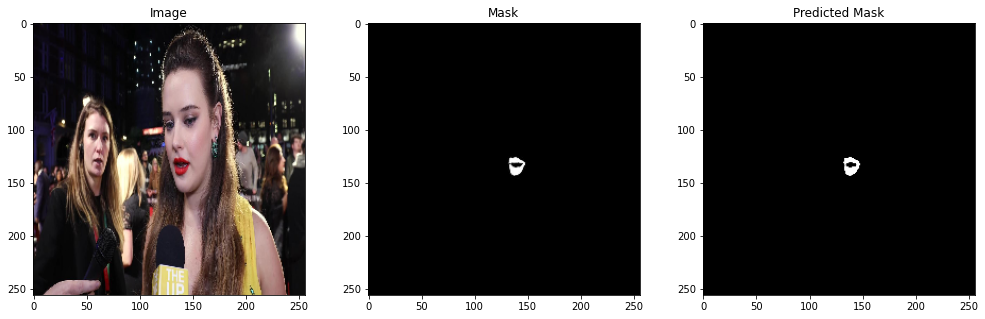


duration: 225s (79ms/step)

Epoch 7/7
step [2854/2854] - loss: 0.1364 - val_loss: 0.0706


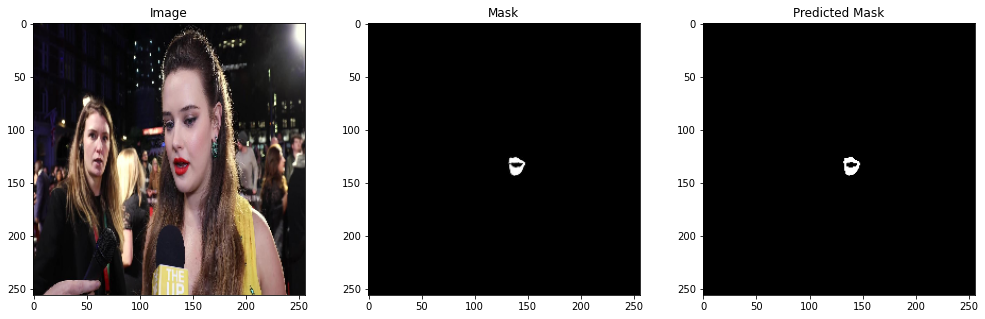


duration: 224s (78ms/step)

Training is finished!


In [29]:
history = model_training(linknet, 
                         criterion, 
                         optimizer, 
                         epochs=7, 
                         device=device, 
                         train_set=train_loader, 
                         valid_set=test_loader)

Уменьшим learning rate.

In [30]:
optimizer.param_groups[0]['lr'] /= 10

Epoch 1/3
step [2854/2854] - loss: 0.1235 - val_loss: 0.0671


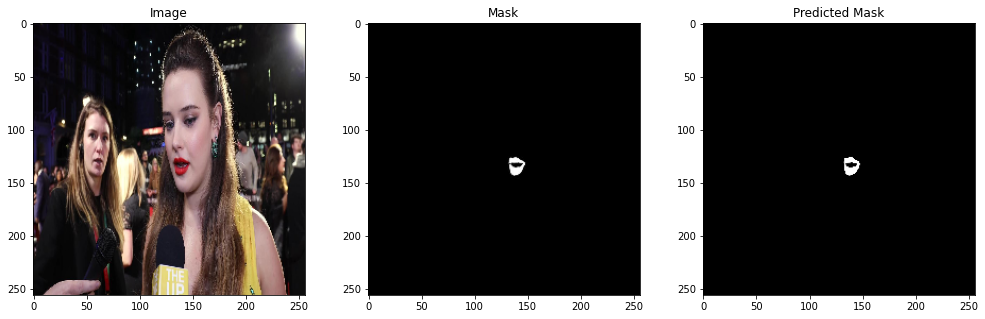


duration: 224s (78ms/step)

Epoch 2/3
step [2854/2854] - loss: 0.1196 - val_loss: 0.0660


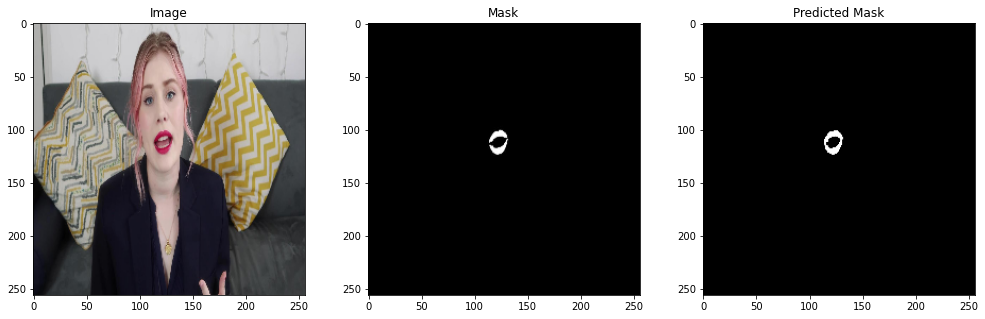


duration: 224s (78ms/step)

Epoch 3/3
step [2854/2854] - loss: 0.1182 - val_loss: 0.0661


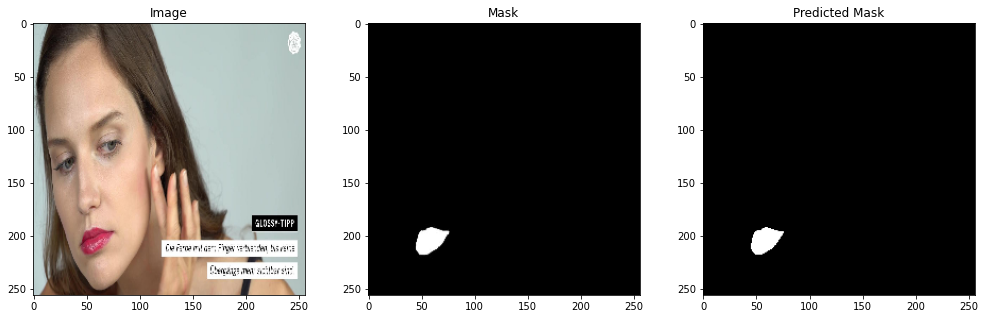


duration: 224s (78ms/step)

Training is finished!


In [31]:
history = model_training(linknet, 
                         criterion, 
                         optimizer, 
                         epochs=3, 
                         device=device, 
                         train_set=train_loader, 
                         valid_set=test_loader)

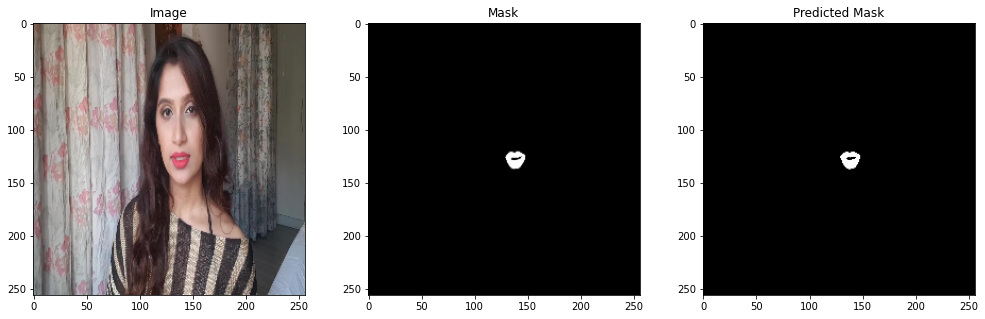

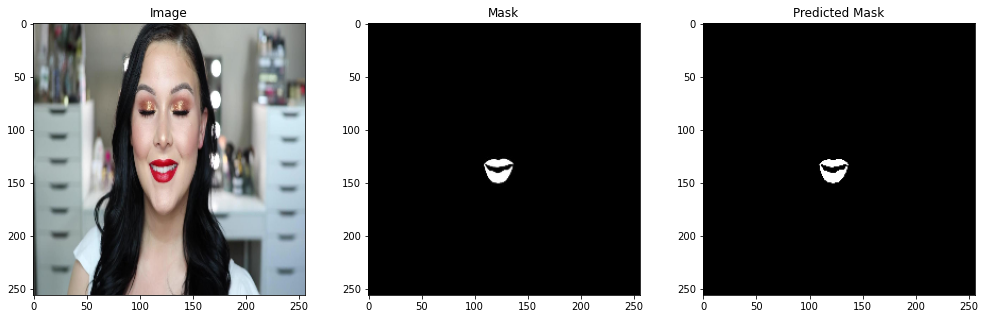

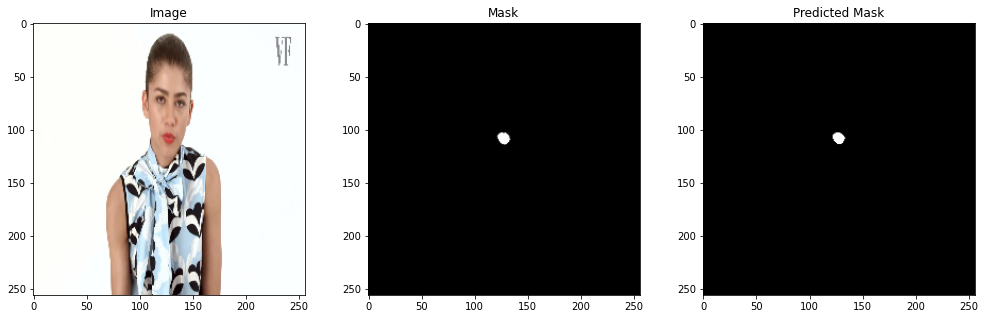

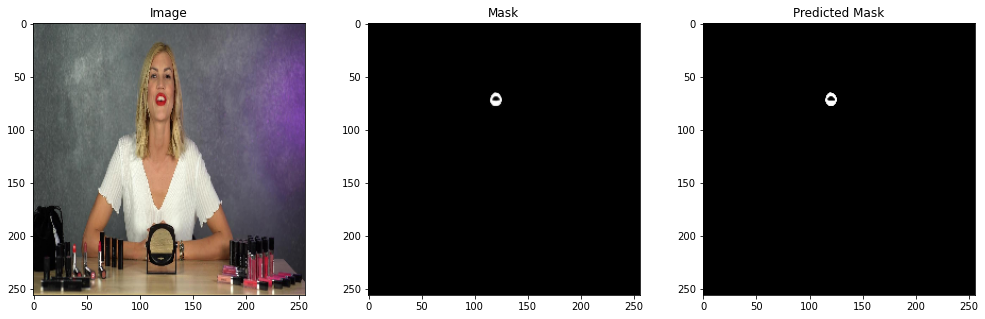

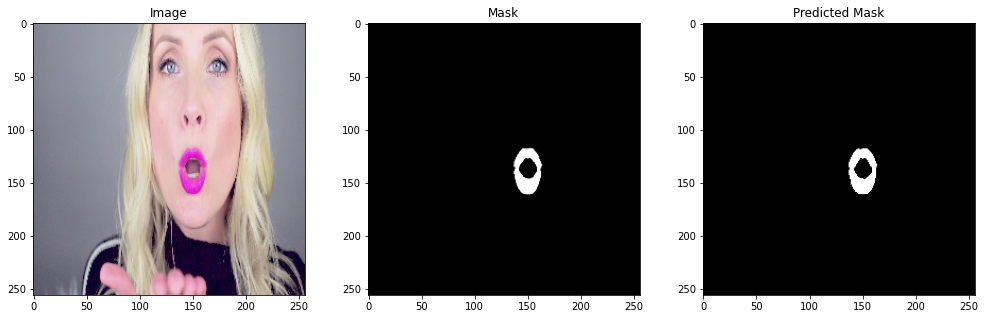

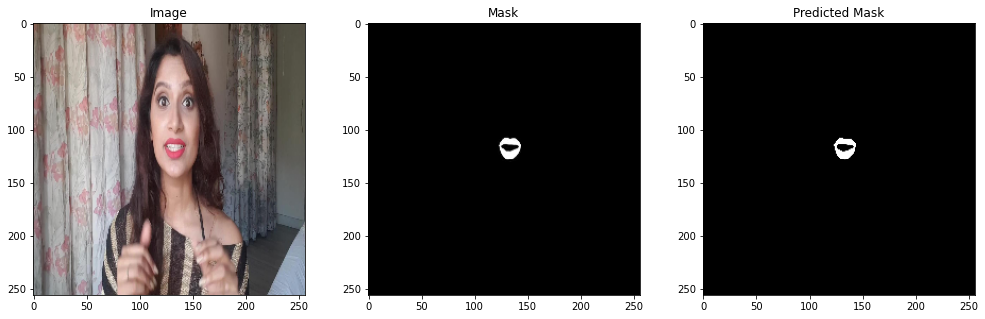

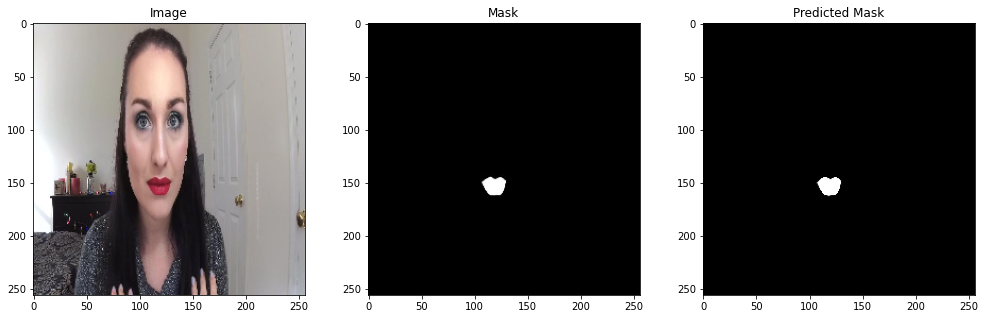

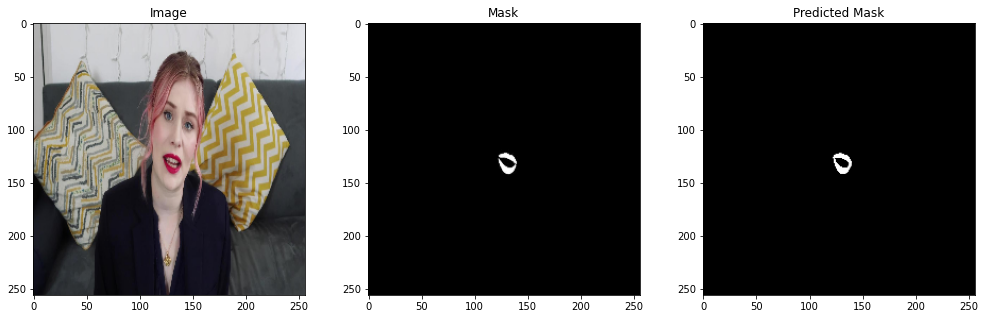

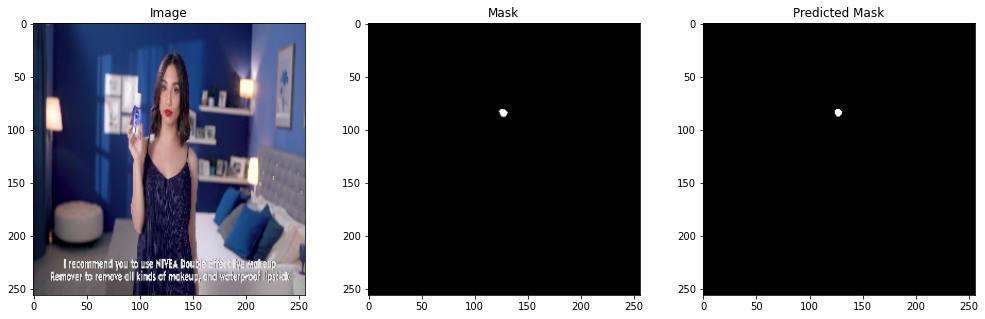

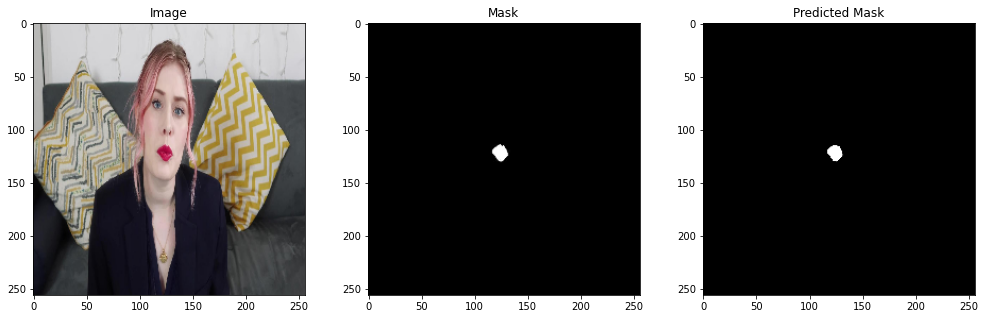

In [37]:
indices = np.random.randint(len(test_dataset), size=10)

linknet.eval()
with torch.no_grad():
    for idx in indices:
        img, mask = test_dataset[idx]
        pred_mask = linknet(img[np.newaxis, :, :, :].to(device))

        draw_imgs(img, mask, pred_mask[0, ...])